In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import time
from torch.optim import Adagrad
from torch.optim import SGD
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import MultiStepLR


print('==> Preparing data..')

# Calculate the mean and standard deviation for each channel of the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_mean = trainset.data.mean(axis=(0, 1, 2)) / 255
train_std = trainset.data.std(axis=(0, 1, 2)) / 255

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomGrayscale(p=0.1),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    # transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std),
])


==> Preparing data..
Files already downloaded and verified


In [2]:
class DropBlock2D(nn.Module):
    def __init__(self, drop_prob, block_size):
        super(DropBlock2D, self).__init__()
        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        if not self.training or self.drop_prob == 0:
            return x

        gamma = self.drop_prob / (self.block_size ** 2)
        for sh in x.shape[2:]:
            gamma *= sh / (sh - self.block_size + 1)

        mask = (torch.rand(x.shape[0], *x.shape[2:], device=x.device) < gamma).float()
        mask = mask / (1 - gamma)
        mask = F.max_pool2d(mask, kernel_size=self.block_size, stride=1, padding=self.block_size // 2)
        mask = mask.unsqueeze(1).expand_as(x)

        return x * (1 - mask)


In [3]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out


In [4]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.25),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.25),
            BasicBlock(64, 128, stride=2),
            BasicBlock(128, 256, stride=2),
            DropBlock2D(drop_prob=0.1, block_size=3),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.25),
            nn.Conv2d(512, 1024, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )

        self.classifier = nn.Sequential(
            nn.Linear(1024 * 1 * 1, 2048),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(2048, num_classes)
        )

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out


Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.407915
Train Epoch: 1 [1280/50000 (3%)]	Loss: 2.346121
Train Epoch: 1 [2560/50000 (5%)]	Loss: 2.143400
Train Epoch: 1 [3840/50000 (8%)]	Loss: 2.082938
Train Epoch: 1 [5120/50000 (10%)]	Loss: 2.164753
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.948318
Train Epoch: 1 [7680/50000 (15%)]	Loss: 1.935058
Train Epoch: 1 [8960/50000 (18%)]	Loss: 2.115353
Train Epoch: 1 [10240/50000 (20%)]	Loss: 1.945145
Train Epoch: 1 [11520/50000 (23%)]	Loss: 1.863975
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.903224
Train Epoch: 1 [14080/50000 (28%)]	Loss: 1.825999
Train Epoch: 1 [15360/50000 (31%)]	Loss: 1.780890
Train Epoch: 1 [16640/50000 (33%)]	Loss: 1.912103
Train Epoch: 1 [17920/50000 (36%)]	Loss: 1.801482
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.873187
Train Epoch: 1 [20480/50000 (41%)]	Loss: 1.648594
Train Epoch: 1 [21760/50000 (43%)]	Loss: 1.712096
Train Epoch: 1 [23040/50000 (46%)]	Loss

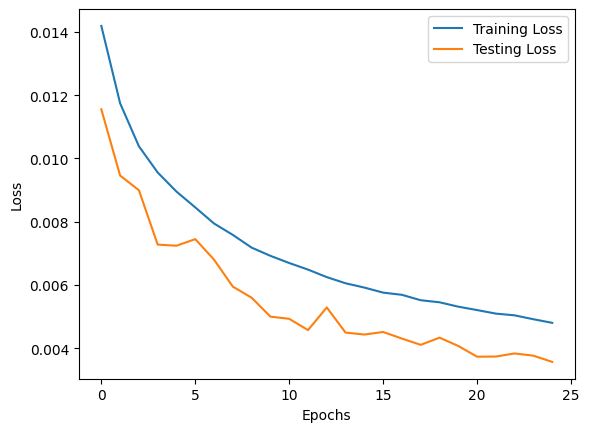

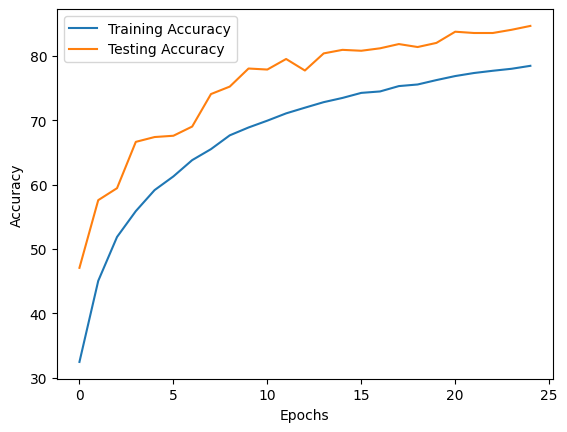

Train Epoch: 26 [0/50000 (0%)]	Loss: 0.748770
Train Epoch: 26 [1280/50000 (3%)]	Loss: 0.568483
Train Epoch: 26 [2560/50000 (5%)]	Loss: 0.557245
Train Epoch: 26 [3840/50000 (8%)]	Loss: 0.580910
Train Epoch: 26 [5120/50000 (10%)]	Loss: 0.661988
Train Epoch: 26 [6400/50000 (13%)]	Loss: 0.613451
Train Epoch: 26 [7680/50000 (15%)]	Loss: 0.517449
Train Epoch: 26 [8960/50000 (18%)]	Loss: 0.548608
Train Epoch: 26 [10240/50000 (20%)]	Loss: 0.680371
Train Epoch: 26 [11520/50000 (23%)]	Loss: 0.701051
Train Epoch: 26 [12800/50000 (26%)]	Loss: 0.701322
Train Epoch: 26 [14080/50000 (28%)]	Loss: 0.597026
Train Epoch: 26 [15360/50000 (31%)]	Loss: 0.610685
Train Epoch: 26 [16640/50000 (33%)]	Loss: 0.592107
Train Epoch: 26 [17920/50000 (36%)]	Loss: 0.570727
Train Epoch: 26 [19200/50000 (38%)]	Loss: 0.553407
Train Epoch: 26 [20480/50000 (41%)]	Loss: 0.528943
Train Epoch: 26 [21760/50000 (43%)]	Loss: 0.664674
Train Epoch: 26 [23040/50000 (46%)]	Loss: 0.485233
Train Epoch: 26 [24320/50000 (49%)]	Loss: 0.62

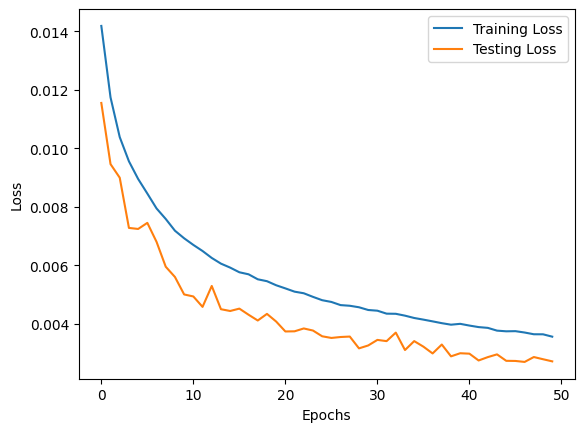

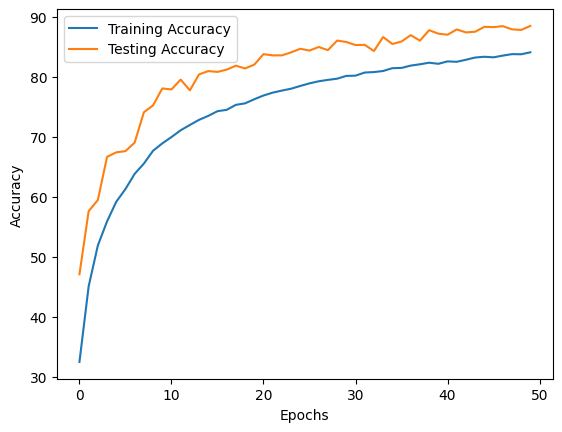

Train Epoch: 51 [0/50000 (0%)]	Loss: 0.432039
Train Epoch: 51 [1280/50000 (3%)]	Loss: 0.430952
Train Epoch: 51 [2560/50000 (5%)]	Loss: 0.368277
Train Epoch: 51 [3840/50000 (8%)]	Loss: 0.291057
Train Epoch: 51 [5120/50000 (10%)]	Loss: 0.451669
Train Epoch: 51 [6400/50000 (13%)]	Loss: 0.449360
Train Epoch: 51 [7680/50000 (15%)]	Loss: 0.412989
Train Epoch: 51 [8960/50000 (18%)]	Loss: 0.466107
Train Epoch: 51 [10240/50000 (20%)]	Loss: 0.467186
Train Epoch: 51 [11520/50000 (23%)]	Loss: 0.346785
Train Epoch: 51 [12800/50000 (26%)]	Loss: 0.393047
Train Epoch: 51 [14080/50000 (28%)]	Loss: 0.446181
Train Epoch: 51 [15360/50000 (31%)]	Loss: 0.369275
Train Epoch: 51 [16640/50000 (33%)]	Loss: 0.471901
Train Epoch: 51 [17920/50000 (36%)]	Loss: 0.249838
Train Epoch: 51 [19200/50000 (38%)]	Loss: 0.356063
Train Epoch: 51 [20480/50000 (41%)]	Loss: 0.402027
Train Epoch: 51 [21760/50000 (43%)]	Loss: 0.367332
Train Epoch: 51 [23040/50000 (46%)]	Loss: 0.340049
Train Epoch: 51 [24320/50000 (49%)]	Loss: 0.34

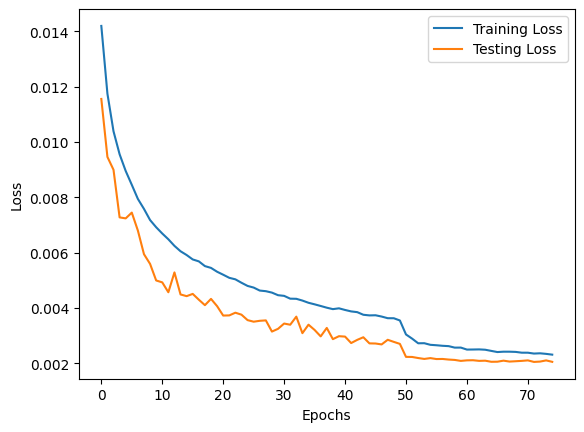

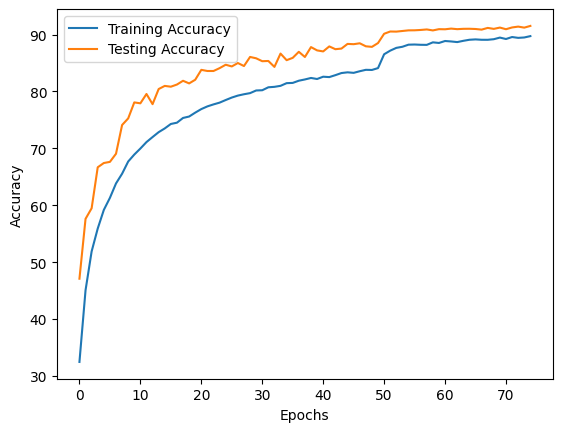

Train Epoch: 76 [0/50000 (0%)]	Loss: 0.277180
Train Epoch: 76 [1280/50000 (3%)]	Loss: 0.273145
Train Epoch: 76 [2560/50000 (5%)]	Loss: 0.293794
Train Epoch: 76 [3840/50000 (8%)]	Loss: 0.341732
Train Epoch: 76 [5120/50000 (10%)]	Loss: 0.340464
Train Epoch: 76 [6400/50000 (13%)]	Loss: 0.374075
Train Epoch: 76 [7680/50000 (15%)]	Loss: 0.449165
Train Epoch: 76 [8960/50000 (18%)]	Loss: 0.271043
Train Epoch: 76 [10240/50000 (20%)]	Loss: 0.183458
Train Epoch: 76 [11520/50000 (23%)]	Loss: 0.302801
Train Epoch: 76 [12800/50000 (26%)]	Loss: 0.279646
Train Epoch: 76 [14080/50000 (28%)]	Loss: 0.419830
Train Epoch: 76 [15360/50000 (31%)]	Loss: 0.293702
Train Epoch: 76 [16640/50000 (33%)]	Loss: 0.283677
Train Epoch: 76 [17920/50000 (36%)]	Loss: 0.354290
Train Epoch: 76 [19200/50000 (38%)]	Loss: 0.218876
Train Epoch: 76 [20480/50000 (41%)]	Loss: 0.224463
Train Epoch: 76 [21760/50000 (43%)]	Loss: 0.312058
Train Epoch: 76 [23040/50000 (46%)]	Loss: 0.216953
Train Epoch: 76 [24320/50000 (49%)]	Loss: 0.26

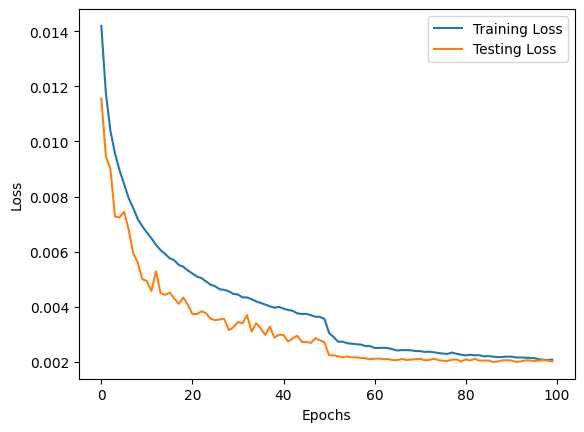

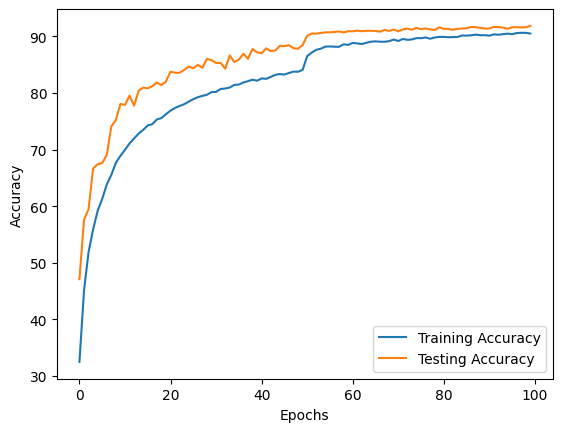

Train Epoch: 101 [0/50000 (0%)]	Loss: 0.214054
Train Epoch: 101 [1280/50000 (3%)]	Loss: 0.209059
Train Epoch: 101 [2560/50000 (5%)]	Loss: 0.347371
Train Epoch: 101 [3840/50000 (8%)]	Loss: 0.161528
Train Epoch: 101 [5120/50000 (10%)]	Loss: 0.418789
Train Epoch: 101 [6400/50000 (13%)]	Loss: 0.251574
Train Epoch: 101 [7680/50000 (15%)]	Loss: 0.238621
Train Epoch: 101 [8960/50000 (18%)]	Loss: 0.317157
Train Epoch: 101 [10240/50000 (20%)]	Loss: 0.209515
Train Epoch: 101 [11520/50000 (23%)]	Loss: 0.355723
Train Epoch: 101 [12800/50000 (26%)]	Loss: 0.181666
Train Epoch: 101 [14080/50000 (28%)]	Loss: 0.236170
Train Epoch: 101 [15360/50000 (31%)]	Loss: 0.251203
Train Epoch: 101 [16640/50000 (33%)]	Loss: 0.281390
Train Epoch: 101 [17920/50000 (36%)]	Loss: 0.238220
Train Epoch: 101 [19200/50000 (38%)]	Loss: 0.257781
Train Epoch: 101 [20480/50000 (41%)]	Loss: 0.228994
Train Epoch: 101 [21760/50000 (43%)]	Loss: 0.265248
Train Epoch: 101 [23040/50000 (46%)]	Loss: 0.300542
Train Epoch: 101 [24320/500

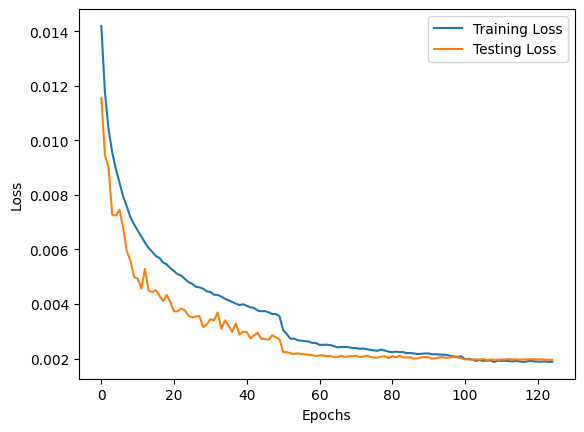

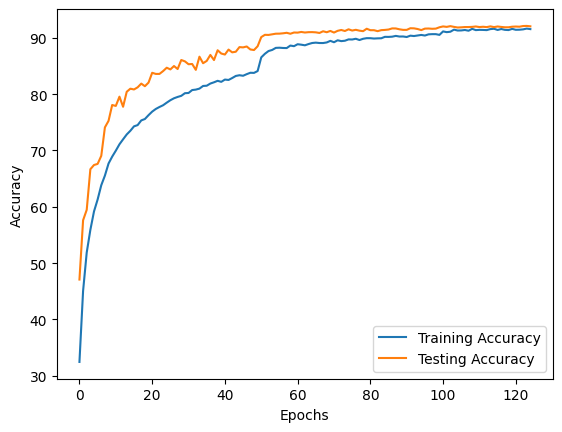

Train Epoch: 126 [0/50000 (0%)]	Loss: 0.170003
Train Epoch: 126 [1280/50000 (3%)]	Loss: 0.244493
Train Epoch: 126 [2560/50000 (5%)]	Loss: 0.163597
Train Epoch: 126 [3840/50000 (8%)]	Loss: 0.325413
Train Epoch: 126 [5120/50000 (10%)]	Loss: 0.186169
Train Epoch: 126 [6400/50000 (13%)]	Loss: 0.281197
Train Epoch: 126 [7680/50000 (15%)]	Loss: 0.284637
Train Epoch: 126 [8960/50000 (18%)]	Loss: 0.184670
Train Epoch: 126 [10240/50000 (20%)]	Loss: 0.250143
Train Epoch: 126 [11520/50000 (23%)]	Loss: 0.167913
Train Epoch: 126 [12800/50000 (26%)]	Loss: 0.231968
Train Epoch: 126 [14080/50000 (28%)]	Loss: 0.298200
Train Epoch: 126 [15360/50000 (31%)]	Loss: 0.170829
Train Epoch: 126 [16640/50000 (33%)]	Loss: 0.284986
Train Epoch: 126 [17920/50000 (36%)]	Loss: 0.282188
Train Epoch: 126 [19200/50000 (38%)]	Loss: 0.291568
Train Epoch: 126 [20480/50000 (41%)]	Loss: 0.236037
Train Epoch: 126 [21760/50000 (43%)]	Loss: 0.275347
Train Epoch: 126 [23040/50000 (46%)]	Loss: 0.215657
Train Epoch: 126 [24320/500

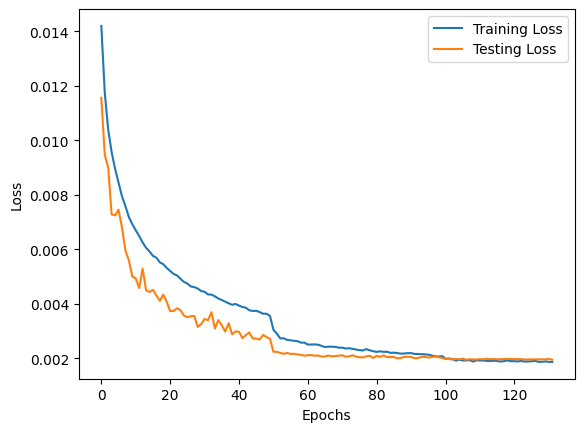

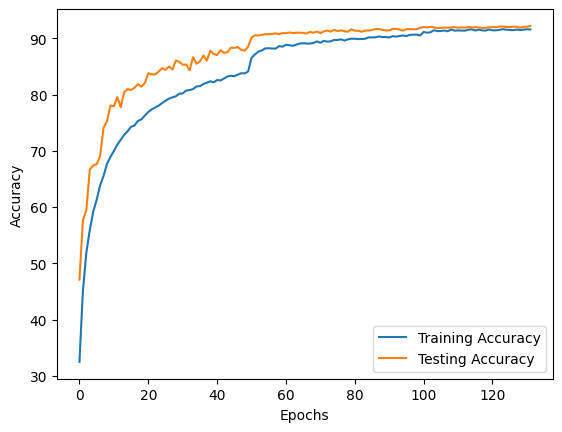

Traning and Testing total execution time is: 19128.993139982224 seconds 


In [5]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    loss_Fn = nn.CrossEntropyLoss()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        Predict = model(data)
        loss = loss_Fn(Predict, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pred = Predict.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)

        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_accuracy = 100. * correct / total
    return avg_train_loss, avg_train_accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    loss_Fn = nn.CrossEntropyLoss()

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = loss_Fn(output, target)  # Removed scaling with data.size(0)
            test_loss += loss.item()  # Removed scaling with data.size(0)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            total += target.size(0)

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / total

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return abs(test_loss), test_accuracy


def main():
    time0 = time.time()
    # Training settings
    batch_size = 128
    epochs = 400
    lr = 0.01
    no_cuda = False
    save_model = False
    use_cuda = not no_cuda and torch.cuda.is_available()
    torch.manual_seed(100)
    device = torch.device("mps")

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size= batch_size, shuffle=True)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(testset, batch_size= batch_size, shuffle=False)

    model = CNNModel().to(device)
    optimizer = SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = MultiStepLR(optimizer, milestones=[50, 100, 150, 200, 250, 300, 350], gamma=0.1)  # Update learning rate at epoch 50 and 100


    train_loss_history = []
    test_loss_history = []
    train_accuracy_history = []
    test_accuracy_history = []

    for epoch in range(1, epochs + 1):
        avg_train_loss, avg_train_accuracy = train(model, device, train_loader, optimizer, epoch)
        avg_test_loss, avg_test_accuracy = test(model, device, test_loader)

        scheduler.step()

        train_loss_history.append(avg_train_loss)
        test_loss_history.append(avg_test_loss)
        train_accuracy_history.append(avg_train_accuracy)
        test_accuracy_history.append(avg_test_accuracy)

        print('\nEpoch: {} - Train Loss: {:.4f}, Train Accuracy: {:.2f}%, Test Loss: {:.4f}, Test Accuracy: {:.2f}%'.format(
            epoch, avg_train_loss, avg_train_accuracy, avg_test_loss, avg_test_accuracy))
        print('Loss Difference: {:.4f}, Accuracy Difference: {:.2f}%\n'.format(
            abs(abs(avg_train_loss) - abs(avg_test_loss)), abs(abs(avg_train_accuracy) - abs(avg_test_accuracy))))

        if avg_test_accuracy > 92.13:
            plt.figure()
            plt.plot(train_loss_history, label='Training Loss')
            plt.plot(test_loss_history, label='Testing Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

            plt.figure()
            plt.plot(train_accuracy_history, label='Training Accuracy')
            plt.plot(test_accuracy_history, label='Testing Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.show()
            break

        if epoch % 25 == 0:
            plt.figure()
            plt.plot(train_loss_history, label='Training Loss')
            plt.plot(test_loss_history, label='Testing Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

            plt.figure()
            plt.plot(train_accuracy_history, label='Training Accuracy')
            plt.plot(test_accuracy_history, label='Testing Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.show()

    if (save_model):
        torch.save(model.state_dict(),"cifar_CNNModel.pt")
    time1 = time.time()
    print('Traning and Testing total execution time is: %s seconds ' % (time1-time0))

if __name__ == '__main__':
    main()
